# Project : Influencers in Social Network

The project is about prediction of human  judgment about who is more influential in the social media from twitter activity. In the following sections I have shown the data preprocessing, data exploration, feature selection, model building and  evaluation. 

In [1]:
#WE have imported the required python library as per requirement 
#while proprocessin, builiding, performance calculation of the model.

from sklearn import svm
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
import os as os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

/home/nivedita/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Let's look into the data to understand the provided features and their correlation etc.

# Reading and preprocessing the dataset

In [3]:
df = pd.read_csv('train.csv')#Loading the train dataset and check the columns
df.columns
#df.head() #Get an overview of the full dataset

Index(['Choice', 'A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3'],
      dtype='object')

Inferences: The provided dataset comprises of pair-wise preference learning task. Each datapoint describes A and B. For each person, 11 pre-computed, non-negative numeric features based on twitter activity. 

Features :follower_count', 'following_count', 'listed_count','mentions_received', 'retweets_received', 'mentions_sent',retweets_sent', 'posts', 'network_feature_1','network_feature_2', 'network_feature_3'.

label: The binary label represents a human judgement about which one of the two individuals is more influential. A label '1' means A is more influential than B. 0 means B is more influential than A.

Therefore, we need to chose some classification model.

We will at first do some data exploration before diving into the modeling. 
Let's check if there any NULL value in the dataset

# Data cleaning

In [4]:
df.isnull().sum()

Choice                 0
A_follower_count       0
A_following_count      0
A_listed_count         0
A_mentions_received    0
A_retweets_received    0
A_mentions_sent        0
A_retweets_sent        0
A_posts                0
A_network_feature_1    0
A_network_feature_2    0
A_network_feature_3    0
B_follower_count       0
B_following_count      0
B_listed_count         0
B_mentions_received    0
B_retweets_received    0
B_mentions_sent        0
B_retweets_sent        0
B_posts                0
B_network_feature_1    0
B_network_feature_2    0
B_network_feature_3    0
dtype: int64

 Therefore, the dataset does not have any NULL value to be dealth with. We observe that the data set has similar features for A and B. Therefore, we can look into the feature importance from the relative values. We would separately collect the data and obtain a datafrme which contains the relative values for A and B.

In [5]:
X_trainA = df[['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3']]
X_trainB = df[['B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3']]
y_train = df['Choice']
#X_trainA.head() get an overview of the data

# Feature engineering: Feature transformation and Data Visualization

Let's visualize the data after transformation. We can apply logarithm tranformation as the dataset consists of positive values and we would also normalize the data and observe the correlation in the features.
 

In [9]:
from pandas.plotting import scatter_matrix

#Logarithm transformation
xlogA = np.log(1+X_trainA)
xlogB = np.log(1+X_trainB)
xlogtrain = xlogA.values -xlogB.values

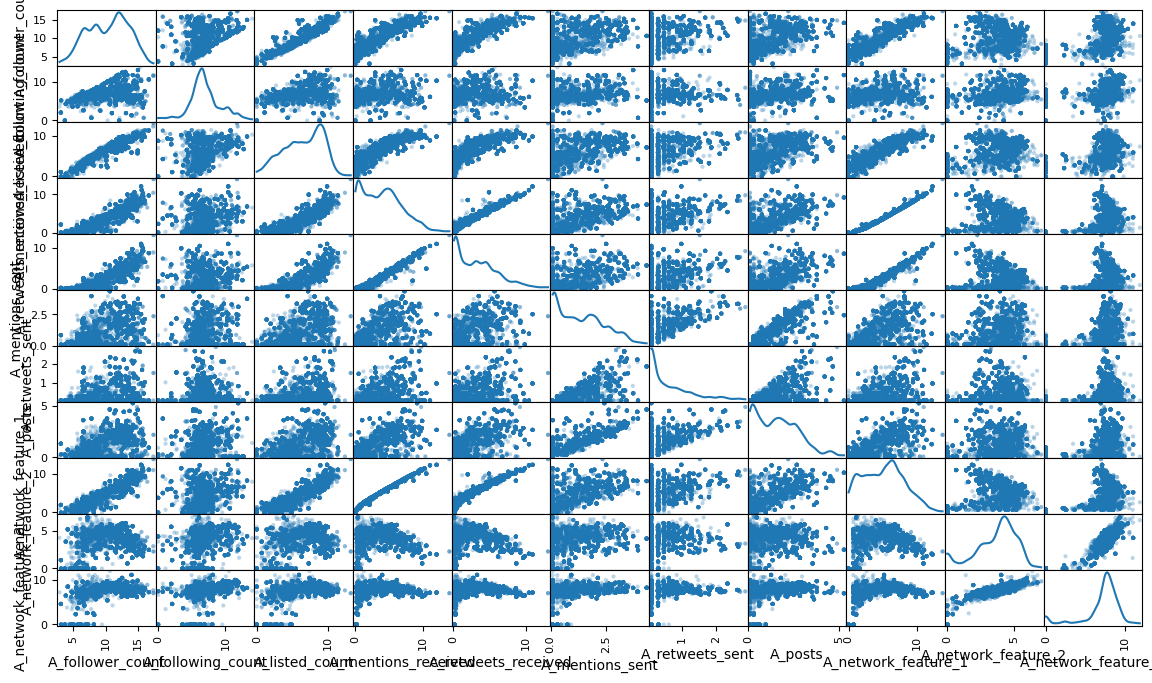

In [10]:
scatter_matrix(xlogA, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

<Axes: >

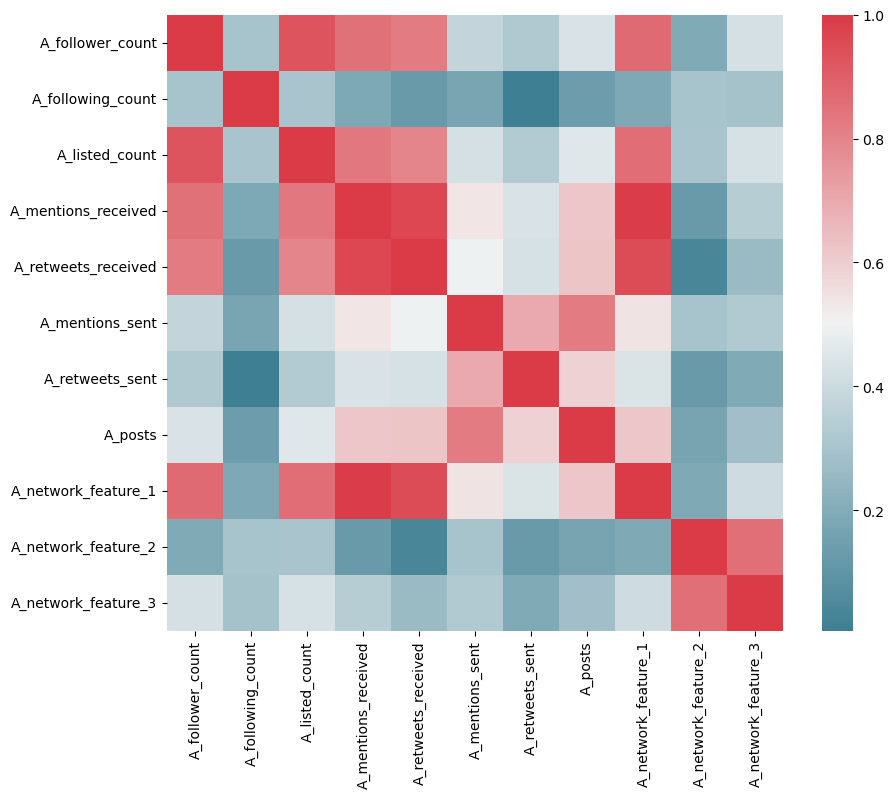

In [11]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = pd.DataFrame(xlogtrain,columns=xlogA.columns).corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool_), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

From both heatmap and scatter matrix it is obvious that there are strong relation between some features in the log transformed data. Let's have a close look into the features with scatter plots.

Text(0, 0.5, 'Following')

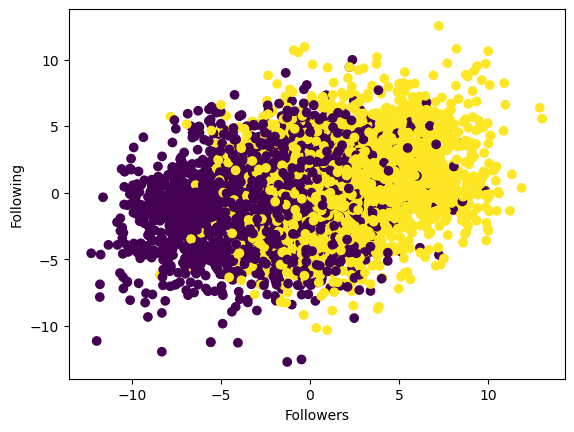

In [12]:
#scatter plot between follower count vs following count
xfollower= xlogA['A_follower_count'].values- xlogB['B_follower_count'].values
yfollowing=xlogA['A_following_count'].values- xlogB['B_following_count'].values
plt.scatter(xfollower, yfollowing,c=y_train, cmap = None)
plt.xlabel('Followers')
plt.ylabel('Following')

Yellow point indicates A is more influential, whereas, purple color indicates B is more influencial. Follower count is more correlated to influence compared to following count. 

Text(0, 0.5, 'Retweets sent')

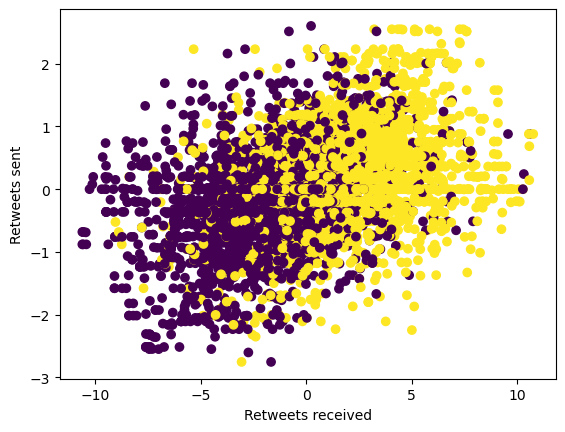

In [13]:
#Plot between received retweet vs sent retweet. 
xrreceived = xlogA['A_retweets_received'].values- xlogB['B_retweets_received'].values
yrsent = xlogA['A_retweets_sent'].values - xlogB['B_retweets_sent'].values
plt.scatter(xrreceived, yrsent, c=y_train, cmap=None)
plt.xlabel('Retweets received')
plt.ylabel('Retweets sent')

Received retweet turns out to be more important than sent retweet.

Text(0, 0.5, 'Mention sent')

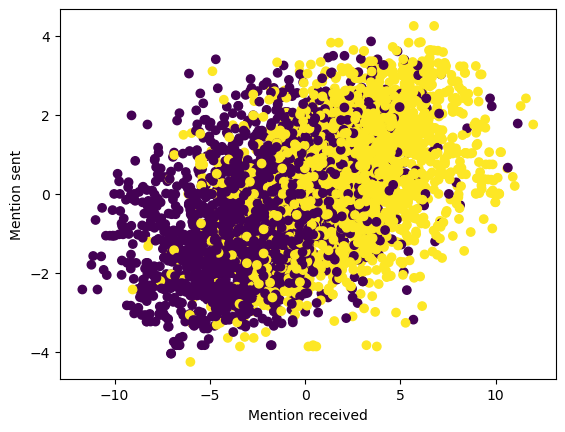

In [14]:
# mentions sent vs mention received plot
xmreceived = xlogA['A_mentions_received'].values - xlogB['B_mentions_received'].values
ymsent = xlogA['A_mentions_sent'].values - xlogB['B_mentions_sent'].values
plt.scatter(xmreceived, ymsent, c=y_train, cmap=None)
plt.xlabel('Mention received')
plt.ylabel('Mention sent')

Mention received is more important than mention sent.

Text(0, 0.5, 'Network feature 1')

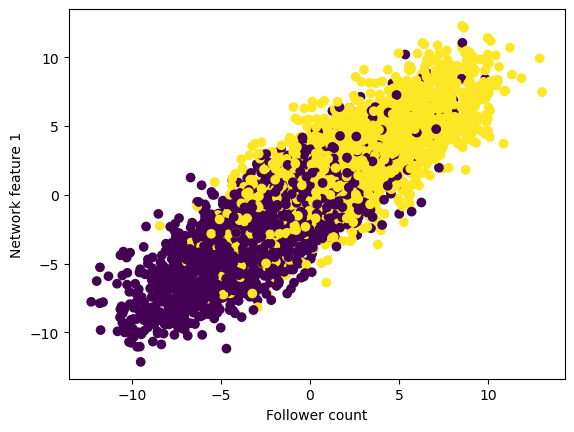

In [15]:
#follower count vs network feature
xfc = xlogA['A_follower_count'].values - xlogB['B_follower_count'].values
yNF1 = xlogA['A_network_feature_1'].values - xlogB['B_network_feature_1'].values
plt.scatter(xfc, yNF1, c=y_train, cmap=None)
plt.xlabel('Follower count')
plt.ylabel('Network feature 1')

We observe a good separation along the diagonal. Both features follower count and network feature are important for influence. 

Text(0, 0.5, 'Network feature 2')

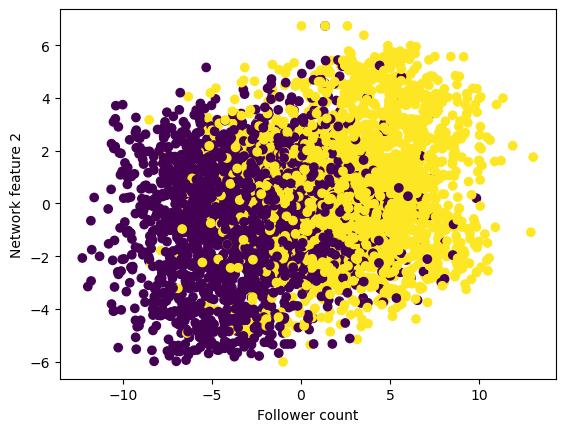

In [16]:
#follower count vs network featue 2 plot
xfc = xlogA['A_follower_count'].values - xlogB['B_follower_count'].values
yNF2 = xlogA['A_network_feature_2'].values - xlogB['B_network_feature_2'].values
plt.scatter(xfc, yNF2, c=y_train, cmap=None)
plt.xlabel('Follower count')
plt.ylabel('Network feature 2')

It seems compared to network feature 1, network feature 2 is less important  for influence. 

Text(0, 0.5, 'Following')

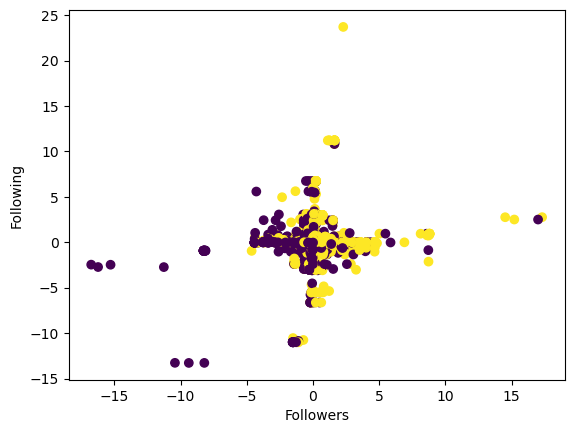

In [17]:
#Scatter plot between Followers and following with normalized data


#Normalize the data with standardscaler method
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler =  StandardScaler()
xnormA = scaler.fit_transform(X_trainA)
xnormB = scaler.fit_transform(X_trainB)

xnormtrain = xnormA-xnormB

xfollowerN= xnormA[:,0]- xnormB[:,0]
yfollowingN=xnormA[:,1]- xnormB[:,1]
plt.scatter(xfollowerN, yfollowingN, c=y_train, cmap=None)
plt.xlabel('Followers')
plt.ylabel('Following')

In this section we normalized the data. Unlike log normalised data, it is not linearly separable. We can perform all the plotting as before. However, we could have calculated our model performance with normalised data and compare that with log transformed data in the next section. Now, let's do feature selection by PCA method. 

# Dimension reduction by PCA

Let's perform by Principal Component Analysis. We would calculate ROC score and decide if we would continue with reduced dimension or not.

(0.4, 1.1)

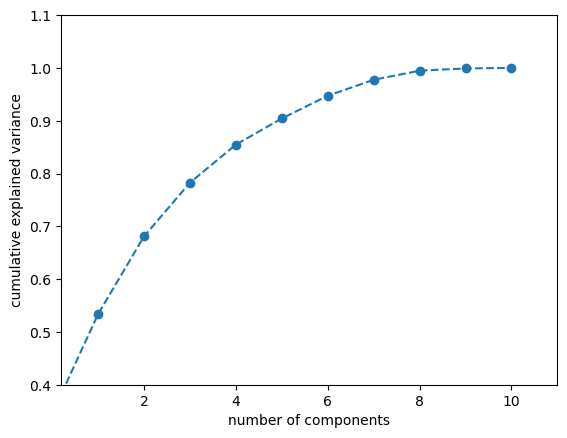

In [18]:
#PCA analysis for feature selection

from sklearn.decomposition import PCA
Xpca = xnormA-xnormB
pca = PCA(n_components=11)
pca.fit(Xpca)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.xlim([0.2, 11])
plt.ylim([0.4, 1.1])

Inferences: From the above plot, it can be assumed that only 6 components track down almost 90% of the cumulative explained variance. 

# Building the model

Now we would build the model with both log transformed and normalised data and observe which provides better result. Since it is a classification problem,We would apply model which are suitable for such scenario e.g., Logistic regression, Support Vector Machine, Gradient Boosting algorithm and Ensemble model such as random Forest algorithm.

Lets work with normalized data and log transformed data and check the performance of the model. We implement Logistic regression first and check the data.

Should we go with selected features we obtained from PCA?

In [19]:
## Modelling and evaluation with reduced dimension data. We would compare our results with 
#non reduced data in the next section
import sklearn.pipeline as skpl
pca = PCA(n_components = 6) #only include first 10 components
LRpca = linear_model.LogisticRegression()#empty model space
pipeline = skpl.Pipeline([('pca', pca), ('logistic', LRpca)]) #create pipeline from pca to logregression space
modelPCALRnorm = pipeline.fit(xnormtrain, y_train)
modelPCALRlog = pipeline.fit(xlogtrain, y_train)
print("20 Fold CV Score PCA-LR from normalised data: ", np.mean(cross_val_score(modelPCALRnorm, xnormtrain, y_train, cv=20, scoring='roc_auc')))
print("20 Fold CV Score PCA-LR from log transformed data: ", np.mean(cross_val_score(modelPCALRlog, xlogtrain, y_train, cv=20, scoring='roc_auc')))

20 Fold CV Score PCA-LR from normalised data:  0.7678470917953293
20 Fold CV Score PCA-LR from log transformed data:  0.8599300584211667


In [20]:
#Start with Logistic Regression model
LR=linear_model.LogisticRegression(fit_intercept=False)
print("20 Fold CV Score LR from normalised data: ", np.mean(cross_val_score(LR, xnormtrain, y_train, cv=20, scoring='roc_auc')))
print("20 Fold CV Score LR from log transformed data: ", np.mean(cross_val_score(LR, xlogtrain, y_train, cv=20, scoring='roc_auc')))
modelLR = LR.fit(xlogtrain, y_train)

20 Fold CV Score LR from normalised data:  0.7985360927547336
20 Fold CV Score LR from log transformed data:  0.8612289430927094


Inference: reduction of dimension doesnot improve. Since, we have only 11 features, we would perform our future calculation with all features.

roc_score with Normalised data: 0.8005719877345143
roc_score with Log transformed data: 0.8671373725589876


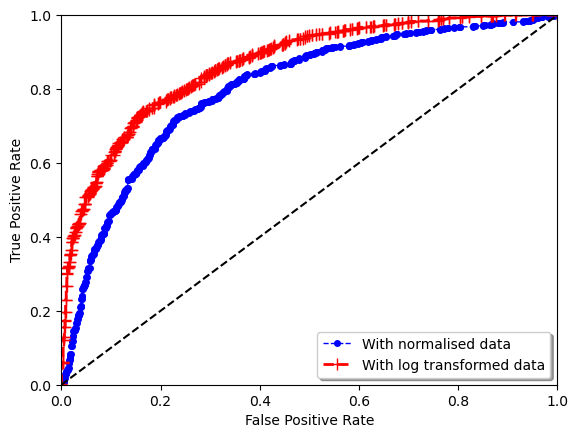

In [21]:

##ROC curve with both log transformed data and normalised data, model = Logistic Regression


from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

#With normalised data
x_trainLRNorm, x_testLRNorm, y_trainLRNorm, y_testLRNorm = train_test_split(xnormtrain, y_train, test_size=.3, random_state=0)
modelLR1 = linear_model.LogisticRegression(fit_intercept=False).fit(x_trainLRNorm, y_trainLRNorm)
y_predLRNorm = modelLR1.predict_proba(x_testLRNorm)[:,1]

#with log transformed data
x_trainLRLog, x_testLRLog, y_trainLRLog, y_testLRLog = train_test_split(xlogtrain, y_train, test_size=.3, random_state=0)
modelLR2 = linear_model.LogisticRegression(fit_intercept=False).fit(x_trainLRLog, y_trainLRLog)
y_predLRLog = modelLR2.predict_proba(x_testLRLog)[:,1]


# Analyze and visualize the results
Normfalse_positive_rate, Normtrue_positive_rate, _ = roc_curve(y_testLRNorm, y_predLRNorm)
roc_aucNorm = auc(Normfalse_positive_rate, Normtrue_positive_rate)
Logfalse_positive_rate, Logtrue_positive_rate, _ = roc_curve(y_testLRLog, y_predLRLog)
roc_aucLog = auc(Logfalse_positive_rate, Logtrue_positive_rate)
plt.plot(Normfalse_positive_rate, Normtrue_positive_rate,color='blue', marker='.', linestyle='dashed',linewidth=1, markersize=8,label='With normalised data'),
plt.plot(Logfalse_positive_rate, Logtrue_positive_rate,color='red', marker='+', linestyle='dashed',linewidth=2, markersize=8,label ='With log transformed data'),
plt.plot([0, 1], [0, 1], 'k--')     # plot the diagonal
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
legend = plt.legend(loc='lower right', shadow=True)
print('roc_score with Normalised data:',roc_aucNorm)
print('roc_score with Log transformed data:',roc_aucLog)

Inference: Log transformed data performs better than normalised data with Logistic regreesion model. We can check other model and compare the results.

In [22]:
#Let's work with SVM,kernel = rbf, linear with both log transformed data set
from sklearn import ensemble
C = 1 #regularization parameter
SVMlinear = svm.SVC(kernel='linear', C=C, probability=True) #linear_svm
SVMrbf = svm.SVC(kernel='rbf', C=C, probability=True) #rbf_svm
print("20 Fold CV Score with SVM with log transformed data, kernel = linear ", np.mean(cross_val_score(SVMlinear, xlogtrain, y_train, cv=20, scoring='roc_auc')))
print("20 Fold CV Score with SVM with transformed data, kernel = rbf ", np.mean(cross_val_score(SVMrbf, xlogtrain, y_train, cv=20, scoring='roc_auc')))

modelSVMlinear = svm.SVC(kernel='linear', C=C, probability=True).fit(xlogtrain, y_train) #linear_svm
modelSVMrbf = svm.SVC(kernel='rbf', C=C, probability=True).fit(xlogtrain, y_train) #rbf_svm

20 Fold CV Score with SVM with log transformed data, kernel = linear  0.8607369300071745
20 Fold CV Score with SVM with transformed data, kernel = rbf  0.8470458674207484


Inference: SVM works better with linear kernel with this logtransformed data. Let's look at the decision boundary.

Text(0, 0.5, 'Following with linear kernel')

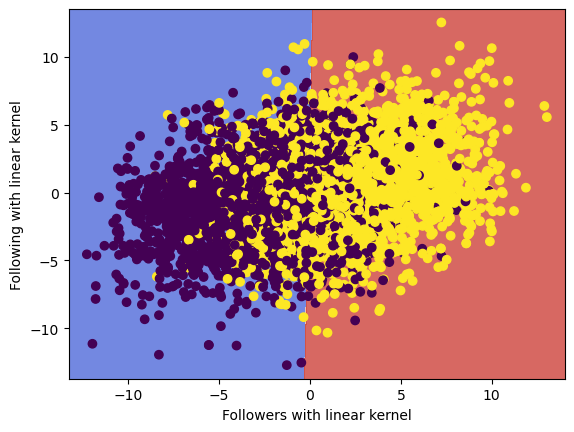

In [23]:
#Decision boundary with SVM, kernel = linear

h = .02  # step size in the mesh
# create a mesh to plot in
xlogtraindb = xlogtrain[:,[0,1]]
x_min, x_max = xlogtrain[:, 0].min() - 1, xlogtrain[:, 0].max() + 1
y_min, y_max = xlogtrain[:, 1].min() - 1, xlogtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
modelSVM1=svm.SVC(kernel='linear', C=C, probability=True).fit(xlogtraindb, y_train) #rbf_svm
Z = modelSVM1.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
xfollower= xlogA['A_follower_count'].values- xlogB['B_follower_count'].values
yfollowing=xlogA['A_following_count'].values- xlogB['B_following_count'].values
plt.scatter(xfollower, yfollowing, c=y_train, cmap=None)
plt.xlabel('Followers with linear kernel')
plt.ylabel('Following with linear kernel')

Text(0, 0.5, 'Following with rbf')

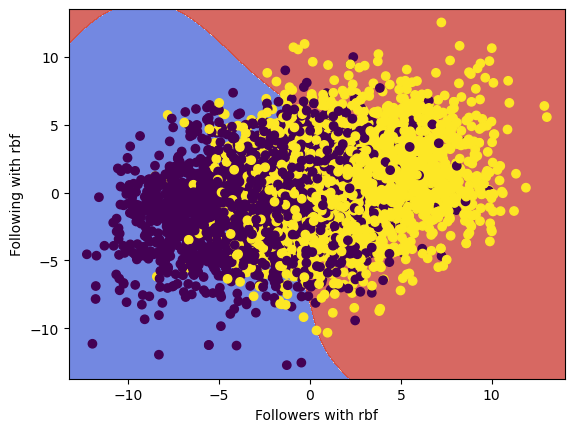

In [24]:
#Decision boundary with SVM, kernel = rbf


h = .02  # step size in the mesh
# create a mesh to plot in
xlogtraindb = xlogtrain[:,[0,1]]
x_min, x_max = xlogtrain[:, 0].min() - 1, xlogtrain[:, 0].max() + 1
y_min, y_max = xlogtrain[:, 1].min() - 1, xlogtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
modelSVM1=svm.SVC(kernel='rbf', C=C, probability=True).fit(xlogtraindb, y_train) #rbf_svm
Z = modelSVM1.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
xfollower= xlogA['A_follower_count'].values- xlogB['B_follower_count'].values
yfollowing=xlogA['A_following_count'].values- xlogB['B_following_count'].values
plt.scatter(xfollower, yfollowing, c=y_train, cmap=None)
plt.xlabel('Followers with rbf')
plt.ylabel('Following with rbf')


Let us try ensemble model to avoid overfitting. We would try GradientBoosting classifier and Random Forest. We have chosen specific values for parameters. However, one can perform gridsearch and find best parameters.

In [25]:
#let us try with  ensemble classifiers 
ensemble1 = ensemble.GradientBoostingClassifier(learning_rate=0.01, max_depth=3)
ensemble2 = ensemble.RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
print("20 Fold CV Score with GB: ", np.mean(cross_val_score(ensemble1, xlogtrain, y_train, cv=20, scoring='roc_auc')))
print("20 Fold CV Score RF: ", np.mean(cross_val_score(ensemble2, xlogtrain, y_train, cv=20, scoring='roc_auc'))
     )

20 Fold CV Score with GB:  0.8574405093747742
20 Fold CV Score RF:  0.859683942664254


In [26]:
modelensemble1 = ensemble1.fit(xlogtrain,y_train)
modelensemble2 = ensemble2.fit(xlogtrain,y_train)

We were given a classification problem to predic who is more influencial. We preprocessed the data by normalising and with a log transformation. To compare both transformed data, model performance has been check with different classifier. It turned out that log transformed data performed better. We chose Logistic regression, Support vector Machine (kernel = rbf, linear), Gradient Boosting Classifier and Random Forest classifier. Support vector machine performed better linear kernel. To overcome overfitting, we have performed cross validation with kfold = 20 in all cases. Furthermore, we checked our model with two ensemble methods. Further improvement of the model can be done with more exhaustive study e.g., with grid search and neural network as well.

From our analysis ensemble method performs better than other classifiers.

# Running the model on the test set

In [27]:
dftest = pd.read_csv('test.csv')
dftest.head()
X_testA = dftest.iloc[:,0:11]
X_testB = dftest.iloc[:,11:]

In [28]:
#Logarithm transformation
xtestlogA = np.log(1+X_testA)
xtestlogB = np.log(1+X_testB)
xtestlog = xtestlogA.values -xtestlogB.values

In [29]:
LR_predict = modelLR.predict_proba(xtestlog)[:,1]
SVM_predict = modelSVMlinear.predict_proba(xtestlog)[:,1] 
GB_predict = modelensemble1.predict_proba(xtestlog)[:,1]
RF_predict = modelensemble2.predict_proba(xtestlog)[:,1]

We need only prediction of 1 class.